In [116]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement calendar (from versions: none)
ERROR: No matching distribution found for calendar

[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
import pandas as pd
import numpy as np

In [118]:
df = pd.read_csv("ufo_sightings.csv")


C:\Users\OWNER'S\AppData\Local\Temp\ipykernel_6848\2533867615.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ufo_sightings.csv")


In [119]:
# Reading CSV with low_memory=False to prevent dtype inference warning
df = pd.read_csv("ufo_sightings.csv", low_memory=False)
#Also the earlier warning will helpful in data cleaning

In [120]:
print(df.info())# Column names, data types, and nulls
print("head rows\n",df.head()) # First 5 rows of actual data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB
None
head rows
               datetime                  city state country     shape  \
0  1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1  1949-10-10 2

In [121]:
print("shape of data", df.shape)  # Shape of the DataFrame, (rows, columns)
print("columns in data", df.columns)  # Column names
print(df.describe())  # Summary statistics for numerical columns

shape of data (80332, 11)
columns in data Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude '],
      dtype='object')
         longitude 
count  80332.000000
mean     -86.772885
std       39.697205
min     -176.658056
25%     -112.073333
50%      -87.903611
75%      -78.755000
max      178.441900


In [122]:
print(df.duplicated().sum()) # Count of duplicate rows

0


The file does not have any duplicate rows, now we can proceed with converting date time to datetime format.

25th percentile (Q1): 30.00
75th percentile (Q3): 600.00
IQR: 570.00
Lower fence: -825.00
Upper fence: 1455.00

Values below lower fence: 0
Values above upper fence: 10501


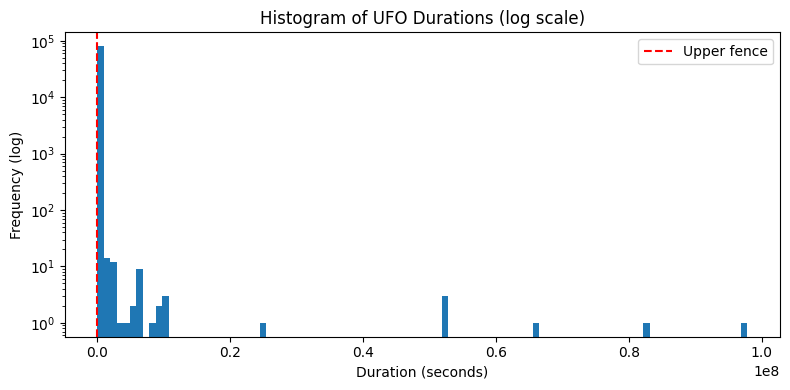

In [123]:
import matplotlib.pyplot as plt
df.columns = df.columns.str.strip()
df['duration (seconds)'] = (
    df['duration (seconds)']
      .astype(str)
      .str.replace(r'[^\d.]', '', regex=True)
      .replace('', '0')
      .astype(float)
)

#Compute IQR and fences
dur = df['duration (seconds)']
q1 = dur.quantile(0.25)
q3 = dur.quantile(0.75)
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

print(f"25th percentile (Q1): {q1:.2f}")
print(f"75th percentile (Q3): {q3:.2f}")
print(f"IQR: {iqr:.2f}")
print(f"Lower fence: {lower_fence:.2f}")
print(f"Upper fence: {upper_fence:.2f}\n")

# Count how many values lie outside
below = (dur < lower_fence).sum()
above = (dur > upper_fence).sum()
print(f"Values below lower fence: {below}")
print(f"Values above upper fence: {above}")

# Visualize the distribution (log scale for clarity)
plt.figure(figsize=(8,4))
plt.hist(dur[dur > 0], bins=100, log=True)
plt.axvline(upper_fence, color='red', linestyle='--', label='Upper fence')
plt.title('Histogram of UFO Durations (log scale)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency (log)')
plt.legend()
plt.tight_layout()
plt.show()


In [124]:
# Convert 'datetime' column to proper datetime format
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
print(df['datetime'].dtypes)

datetime64[ns]


In [125]:
print("Invalid/missing dates:", df['datetime'].isnull().sum())
print(df['datetime'].head())

Invalid/missing dates: 0
0   1949-10-10 20:30:00
1   1949-10-10 21:00:00
2   1955-10-10 17:00:00
3   1956-10-10 21:00:00
4   1960-10-10 20:00:00
Name: datetime, dtype: datetime64[ns]


We can now proceed to extract year and month and hour from 'datetime' column for trend analysis


In [126]:
# Extract year, month, and hour into new columns

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

In [127]:
# count missing per column
missing = df.isnull().sum().sort_values(ascending=False)
missing_summary = pd.DataFrame({
    'missing_count': missing
})

print(missing_summary[missing_summary['missing_count'] > 0])

          missing_count
country            9670
state              5797
shape              1932
comments             15


In [128]:
#clean string columns
for col in ['city','state','country','shape']:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({'nan': None})
    )
#Show missing counts before filling
print("Missing BEFORE fill:")
print(df[['country','state','shape','comments']].isnull().sum(), "\n")

#Filling missing: categorical as 'unknown' and  comments as empty string
df[['country','state','shape']] = df[['country','state','shape']].fillna('unknown')
df['comments'] = df['comments'].fillna('')

# Verifying no more missing
print("Missing AFTER fill:")
print(df[['country','state','shape','comments']].isnull().sum(), "\n")

#peek

print(df['country'].value_counts().head())



Missing BEFORE fill:
country     9670
state       5797
shape       1932
comments      15
dtype: int64 

Missing AFTER fill:
country     0
state       0
shape       0
comments    0
dtype: int64 

country
us         65114
unknown     9670
ca          3000
gb          1905
au           538
Name: count, dtype: int64


Cleaning complete, we will now be analyzing trends

year
1906       1
1910       2
1916       1
1920       1
1925       1
        ... 
2010    4283
2011    5107
2012    7356
2013    7038
2014    2260
Name: count, Length: 87, dtype: int64


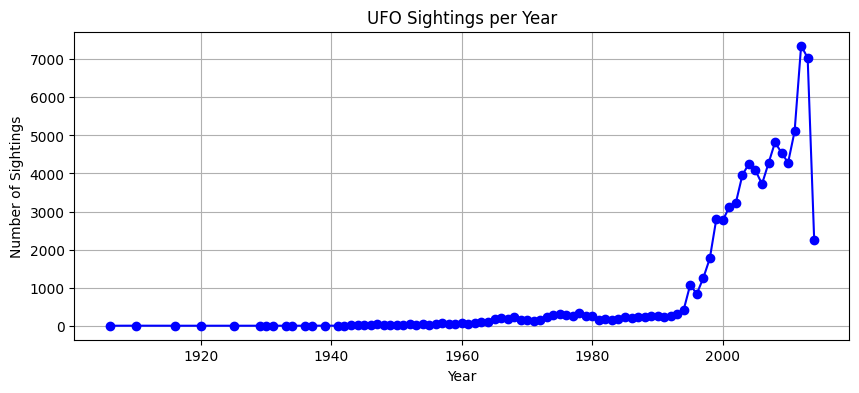

In [129]:
import matplotlib.pyplot as plt

#yearly counts of UFO sightings
yearly_counts = df['year'].value_counts().sort_index()

#Display the counts
print(yearly_counts)

# Plotting the trend of UFO sightings over the years
yearly_counts.plot(kind='line', figsize=(10,4), marker='o', color='blue')
plt.title('UFO Sightings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.grid(True)




It is observed from above that ufo signtings were more consistent from 1940s to 2000s but highest number of sightings were reported in 2013

month
1     5689
2     4667
3     5449
4     5527
5     5292
6     8130
7     9542
8     8638
9     7588
10    7406
11    6740
12    5664
dtype: int64


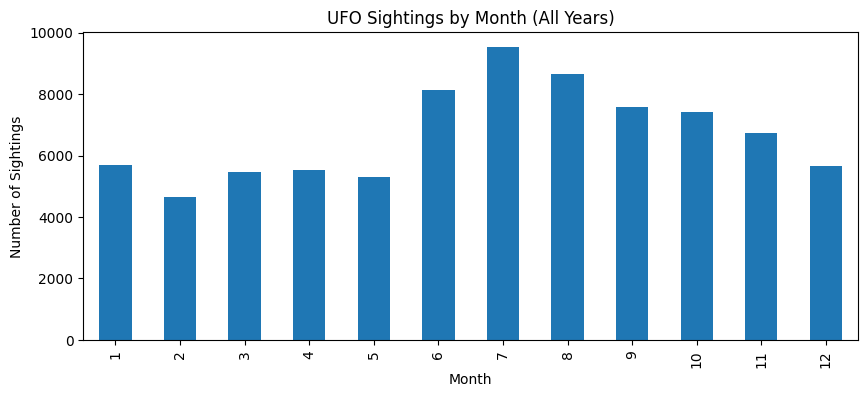

In [130]:
# Aggregating counts by month (1–12)
monthly_counts = df.groupby('month').size().sort_index()

# Display the monthly counts
print(monthly_counts)

#Plotting the distribution
monthly_counts.plot(kind='bar', figsize=(10,4))
plt.title('UFO Sightings by Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.show()

Monthly UFO sightings indicate seasonality: the highest activity occurs in midsummer (June–August), peaking in July, while winter months see roughly 40–50% fewer reports. This is clear sign that favorable weather and increased outdoor activity drive the volume of sightings.

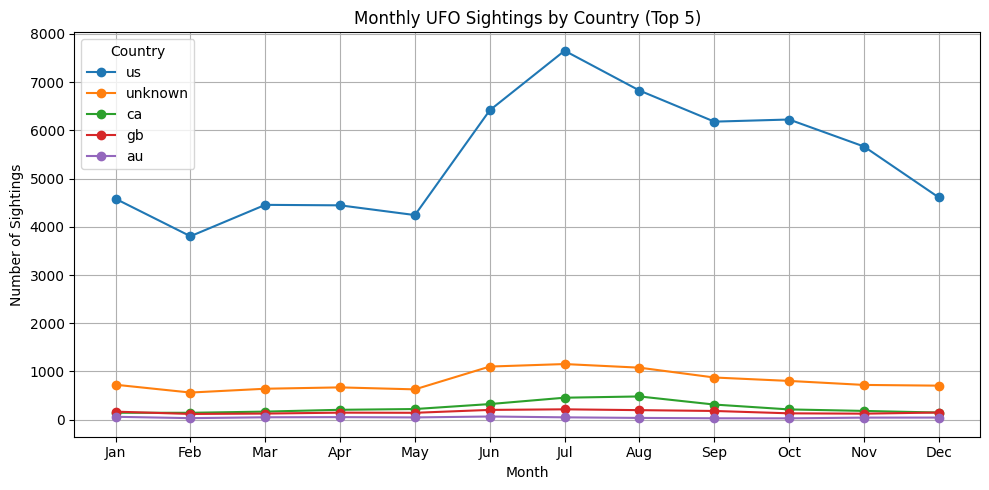

In [131]:
import calendar
country_monthly = (
    df
    .groupby(['country','month'])
    .size()
    .unstack(fill_value=0)        # months 1–12 as columns
)

#Focus on top 5 countries by total sightings
top5 = df['country'].value_counts().nlargest(5).index
cm_top5 = country_monthly.loc[top5]

#Replace month numbers with abbreviations on the x-axis
months = [calendar.month_abbr[i] for i in cm_top5.columns]

#Plot
plt.figure(figsize=(10,5))
for country in cm_top5.index:
    plt.plot(months, cm_top5.loc[country], marker='o', label=country)
plt.title('Monthly UFO Sightings by Country (Top 5)')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()
plt.show()

The U.S. (blue) dominates UFO reports by a wide margin in every month, peaking sharply in midsummer (July) with over 7,500 sightings. The ‘unknown’ category (orange) follows a very similar seasonal curve, suggesting that many unclassified reports occur with the same summer-driven cadence. Canada (green), the U.K. (red), and Australia (purple) register far fewer reports but also show their highest counts in June–August, consistent with northern-hemisphere summer patterns (and southern-hemisphere winter for Australia). Overall, there’s a clear global summer peak in UFO reporting

## Which U.S. regions (states) dominate?

Top 10 U.S. states by UFO sightings:
 state
ca    8912
wa    3966
fl    3835
tx    3447
ny    2980
il    2499
az    2414
pa    2366
oh    2275
mi    1836
Name: count, dtype: int64


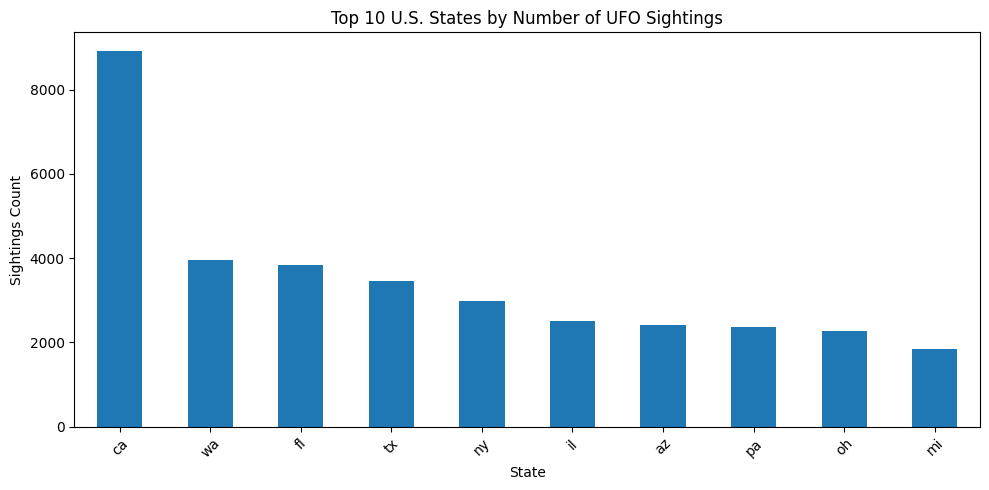

In [132]:
us_df = df[df['country'] == 'us']

#Counting sightings per state
state_counts = us_df['state'].value_counts()

#Print the top 10 states
print("Top 10 U.S. states by UFO sightings:\n", state_counts.head(10))

#Plotting the top 10
plt.figure(figsize=(10,5))
state_counts.head(10).plot(kind='bar')
plt.title('Top 10 U.S. States by Number of UFO Sightings')
plt.xlabel('State')
plt.ylabel('Sightings Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

10 U.S. States with the Fewest UFO Sightings:
 state
ak    319
hi    262
vt    260
ri    228
sd    183
wy    175
de    166
nd    129
pr     25
dc      7
Name: count, dtype: int64 



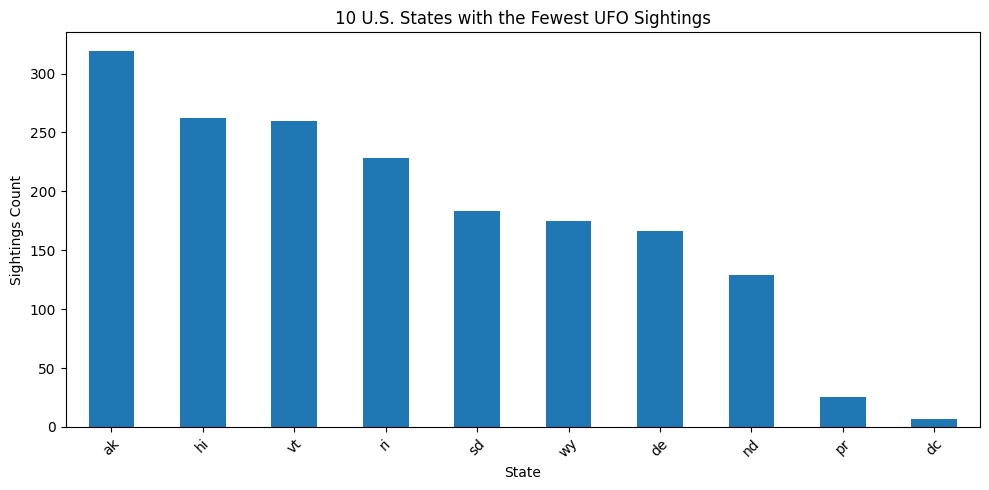

In [133]:
least10 = state_counts.tail(10)
print("10 U.S. States with the Fewest UFO Sightings:\n", least10, "\n")

#Plot the bottom 10
plt.figure(figsize=(10,5))
least10.plot(kind='bar')
plt.title('10 U.S. States with the Fewest UFO Sightings')
plt.xlabel('State')
plt.ylabel('Sightings Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

California leads UFO reports by a wide margin—driven by its huge population and active observers—while sparsely populated areas like D.C., Puerto Rico, and Alaska sit at the bottom with the fewest sightings.

In [136]:
import folium
from IPython.display import display
from folium.plugins import HeatMap
df['latitude']  = pd.to_numeric(df['latitude'],  errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')  # note the trailing space
coords = df.dropna(subset=['latitude','longitude'])

#Prepared heat‐map data as a list of [lat, lon] pairs
heat_data = coords[['latitude','longitude']].values.tolist()

#Creating a base map centered at [0,0]
m = folium.Map(location=[0, 0], 
               tiles='CartoDB positron', 
               zoom_start=2)

#Adding the heatmap layer
HeatMap(
    heat_data, 
    radius=8,     # adjust point radius
    blur=15,      # softer vs. sharper hotspots
    max_zoom=5
).add_to(m)

#Save to an HTML file and open in your browser
m.save('ufo_global_heatmap.html')
print("Heatmap saved as ufo_global_heatmap.html")
display(m)

Heatmap saved as ufo_global_heatmap.html


The global heatmap of UFO sightings reveals that the most intense clusters coincide with highly populated urban and suburban areas and robust reporting networks.
 These patterns indicate that the volume of reports is driven less by unique regional phenomena and more by observer density and the availability of channels for reporting.

Top 10 UFO shapes:
 shape
light        16565
triangle      7865
circle        7608
unknown       7516
fireball      6208
other         5649
sphere        5387
disk          5213
oval          3733
formation     2457
Name: count, dtype: int64 



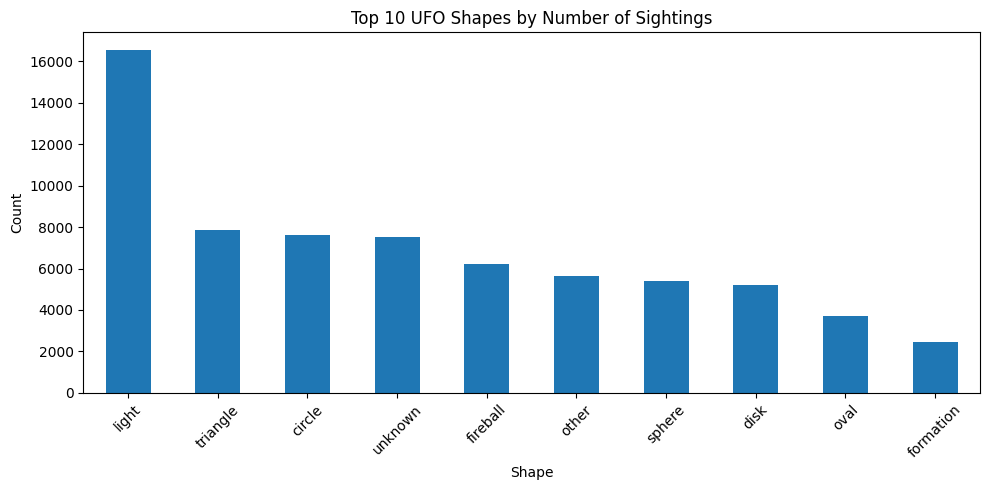

In [137]:
# Counting the number of sightings by shape
shape_counts = df['shape'].value_counts()
print("Top 10 UFO shapes:\n", shape_counts.head(10), "\n")

#Plot the distribution of the top 10 shapes
plt.figure(figsize=(10,5))
shape_counts.head(10).plot(kind='bar')
plt.title('Top 10 UFO Shapes by Number of Sightings')
plt.xlabel('Shape')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The “light” category dominates UFO reports, but its broad, non-descriptive nature means many of those sightings are likely mundane misidentifications.

In [138]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords

lights = df[df['shape'] == 'light'].copy()

# Tokenize comments and get top 20 words
texts = lights['comments'].str.replace(r'[^a-z\s]', ' ', regex=True)
tokens = texts.str.split().explode()
tokens = tokens[tokens.str.len() > 2]           # drop very short tokens
tokens = tokens[~tokens.isin(stopwords)]        # drop stopwords
top_words = tokens.value_counts().head(20)
print("\nTop 20 words in 'light' comments:\n", top_words)

# Flag likely mundane 'light' reports
keywords = ['star','planet','venus','mars','iss','satellite',
            'airplane','helicopter','drone','lantern','flare']
pattern = rf'\b(?:{"|".join(keywords)})\b'
lights.loc[:, 'likely_mundane'] = lights['comments'].str.contains(pattern, regex=True, na=False)
print("\nLikely mundane 'light' reports:", 
      lights['likely_mundane'].sum(), 
      f"({lights['likely_mundane'].mean():.2%})")




Top 20 words in 'light' comments:
 comments
light     7157
lights    4364
sky       4342
bright    2893
moving    2583
right     1883
white     1741
red       1451
orange    1342
object    1329
like      1218
star      1163
saw       1050
seen       993
night      900
ight       854
quot       830
ote        794
fast       780
speed      677
Name: count, dtype: int64

Likely mundane 'light' reports: 1468 (8.86%)


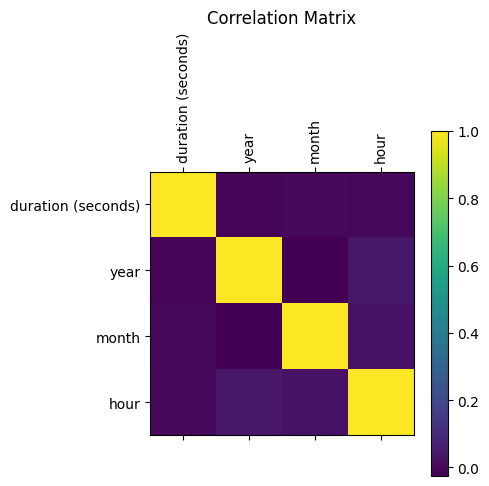

C:\Users\OWNER'S\AppData\Local\Temp\ipykernel_6848\2176210276.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top5, whis=1.5)


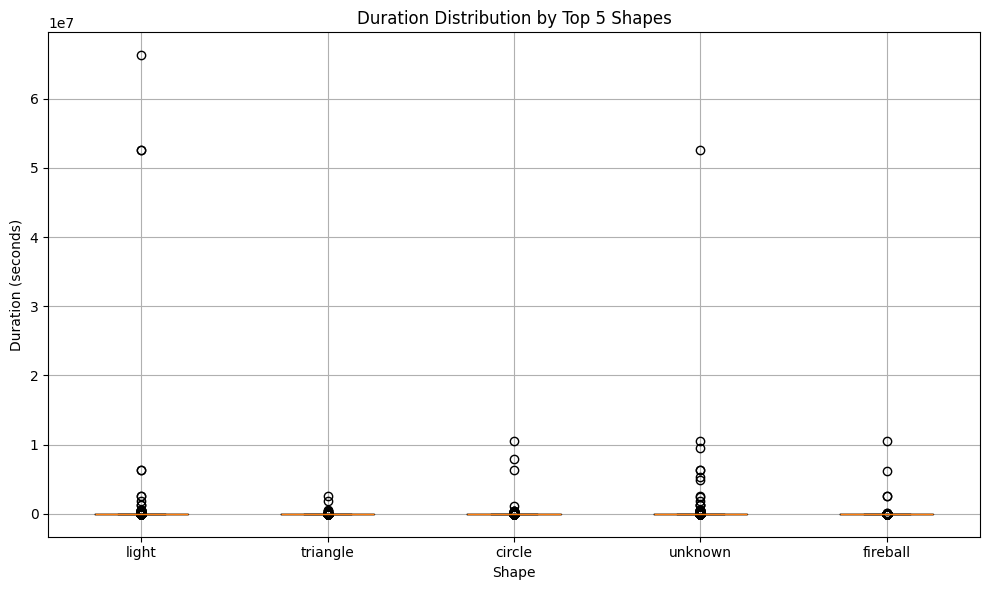

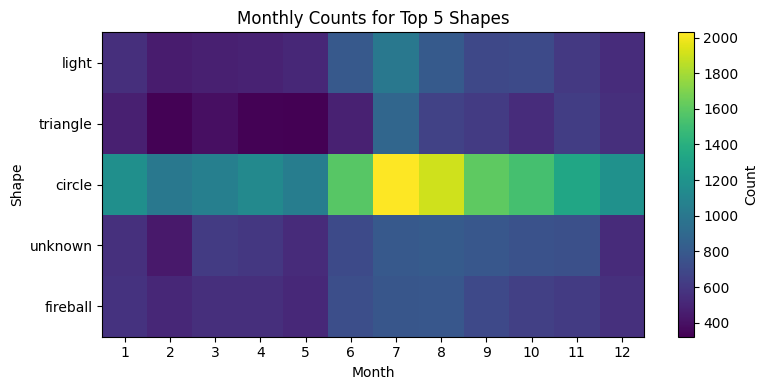

In [139]:



df['duration (seconds)'] = (
    df['duration (seconds)']
      .astype(str)
      .str.replace(r'[^\d.]','', regex=True)
)
df['duration (seconds)'] = pd.to_numeric(df['duration (seconds)'], errors='coerce').fillna(0)
df['shape'] = (
    df['shape']
      .astype(str).str.strip().str.lower()
      .replace({'nan': None})
      .fillna('unknown')
)

#Correlation matrix of numeric features
num_cols = ['duration (seconds)', 'year', 'month', 'hour']
corr = df[num_cols].corr()
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticks(range(len(num_cols))); ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

#Boxplot: duration by shape for the top 5 shapes
top5 = df['shape'].value_counts().head(5).index.tolist()
data = [df[df['shape']==s]['duration (seconds)'] for s in top5]
plt.figure(figsize=(10,6))
plt.boxplot(data, labels=top5, whis=1.5)
plt.title('Duration Distribution by Top 5 Shapes')
plt.xlabel('Shape')
plt.ylabel('Duration (seconds)')
plt.grid(True)
plt.tight_layout()
plt.show()

#Heatmap: monthly counts for those top 5 shapes
pivot = (
    df[df['shape'].isin(top5)]
    .groupby(['shape','month'])
    .size()
    .unstack(fill_value=0)
)
fig, ax = plt.subplots(figsize=(8,4))
im = ax.imshow(pivot.values, aspect='auto')
ax.set_xticks(np.arange(12));    ax.set_xticklabels(range(1,13))
ax.set_yticks(np.arange(len(top5))); ax.set_yticklabels(top5)
plt.title('Monthly Counts for Top 5 Shapes')
plt.xlabel('Month')
plt.ylabel('Shape')
plt.colorbar(im, label='Count')
plt.tight_layout()
plt.show()


The correlation matrix indicates virtually no linear association among duration, year, month, and hour, so temporal features contribute independently.

Boxplots show “triangle” sightings have the longest and most variable durations, whereas “light” and “circle” have shorter medians but extreme outliers, highlighting data‐entry and reporting inconsistencies.

The monthly heatmap reveals a pronounced summer peak (June–August) for all top shapes, with “circle” leading in volume and “triangle”/“fireball” exhibiting the sharpest midsummer spikes.

These combined insights emphasize the need for shape‐specific duration filtering and seasonal adjustment to accurately characterize UFO sighting patterns